## IMPORTS

In [1]:
from os import walk
from os.path import join
import pandas as pd
import time
import numpy as np


import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

from wordcloud import WordCloud

from PIL import Image

In C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Nagaraj U\Downloads\anaconda

## Constants

In [90]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

EMAIL_TEXT_JSON_PATH = 'SpamData/01_Processing/email-text.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'


SPAM_CAT = 1
NONSPAM_CAT = 0
VOCABULARY_SIZE = 2500

WHALE_FILE =  'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'

THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

### Reading files

In [3]:
stream = open(EXAMPLE_FILE,encoding='latin_1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
stream = open(EXAMPLE_FILE,encoding='latin_1')

is_body = False
lines = []
for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body=True

stream.close()

message_body = '\n'.join(lines)
print(message_body)





Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

## Generator function

In [6]:
def generator_function(N):
    for num in range(N):
        yield num ** 2

In [7]:
for i in generator_function(3):
    print(i)

0
1
4


## Email Body Extraction

In [8]:
def get_email_body(path):
    
    for root, dirname, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root,file_name)

            stream = open(filepath, encoding='latin_1')
            is_body = False
            lines = []
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body=True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body


In [9]:
def dataframe_from_directory(path,classification):
    rows = []
    rows_name = []
    for file_name, email_body in get_email_body(path):
        rows.append({'MESSAGE' : email_body, 'CATEGORY' : classification})
        rows_name.append(file_name)
        
    return pd.DataFrame(rows,index=rows_name)
        
    

In [10]:
spam_emails =  dataframe_from_directory(SPAM_1_PATH,SPAM_CAT) # 1 : spam 0 : nonspam
spam_emails = spam_emails.append( dataframe_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
non_spam_emails = dataframe_from_directory(NONSPAM_1_PATH,NONSPAM_CAT)
non_spam_emails = non_spam_emails.append(dataframe_from_directory(NONSPAM_2_PATH,NONSPAM_CAT))
print(non_spam_emails.shape)
non_spam_emails.head()

(3901, 2)


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
data = pd.concat([spam_emails,non_spam_emails])
print(f' shape of entire dataframe is {data.shape}')

 shape of entire dataframe is (5799, 2)


In [14]:
data.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [15]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


## Checking for null or missing values

In [16]:
# NOTE : there is diff between missing(length = 0) and null (none type object) messages


data['MESSAGE'].isnull().values.any()

False

In [17]:
# No null emails 

data['MESSAGE'].isnull().sum()

0

In [18]:
(data['MESSAGE'].str.len() == 0 )

00001.7848dde101aa985090474a91ec93fcf0    False
00002.d94f1b97e48ed3b553b3508d116e6a09    False
00003.2ee33bc6eacdb11f38d052c44819ba6c    False
00004.eac8de8d759b7e74154f142194282724    False
00005.57696a39d7d84318ce497886896bf90d    False
                                          ...  
01396.61983fbe6ec43f55fd44e30fce24ffa6    False
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    False
01398.169b51731fe569f42169ae8f948ec676    False
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    False
01400.f897f0931e461e7b2e964d28e927c35e    False
Name: MESSAGE, Length: 5799, dtype: bool

In [19]:
# total number of empty emails

(data['MESSAGE'].str.len() == 0 ).sum()

3

In [20]:
# Locating empty emails

data[data['MESSAGE'].str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Removing system file entries (cmds files)

In [21]:
data = data.drop(['cmds'])

In [22]:
data.shape  #removed 3 files

(5796, 2)

## Assigning document ID to each row 

In [23]:
document_ids = range(0,len(data.index))
document_ids
data['DOC_ID'] = document_ids  # column to hold index 0-5796

In [24]:
data['FILE_NAME'] = data.index   #creating separate column to hold original file names
data.set_index('DOC_ID',inplace=True)  #changing index from filenales to DOC_ID
data.head()
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


## storing emails data to json file

In [25]:
data.to_json(EMAIL_TEXT_JSON_PATH)

## calculating amount of spam and legit emails

In [26]:
data['CATEGORY'].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [27]:
amount_of_spam = data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

category_names = ['spam' , 'legit emails']
sizes = [amount_of_spam ,amount_of_ham]

chart_colors = ['#b2ebf2','#e97171']

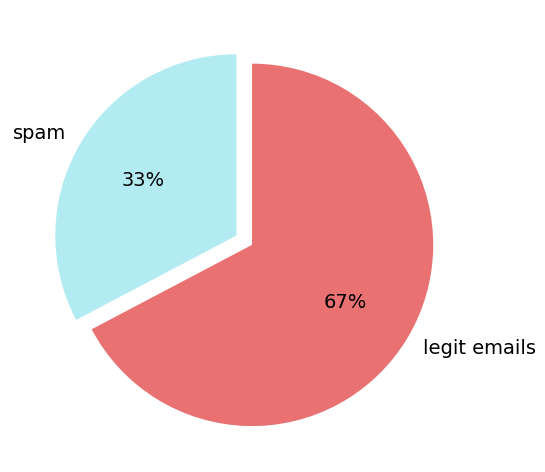

In [28]:
plt.figure(figsize=(6,6),dpi = 100) # dpi: density of pixels per inch
plt.pie(sizes ,labels=category_names,textprops={'fontsize' : 14} ,startangle=90,colors=chart_colors,explode=[0,0.1],autopct='%1.0f%%')
plt.show()

## Natural Language processing

### Text pre-processing

In [29]:
message = 'all Work and No play make jack Dull boy !'
message.lower()

'all work and no play make jack dull boy !'

## Download NLTK resources (tokenizer and stopwords)

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Nagaraj
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Tokenizing

In [31]:
word_tokenize(message.lower())


['all', 'work', 'and', 'no', 'play', 'make', 'jack', 'dull', 'boy', '!']

## stowords

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Nagaraj
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
# Removing stopwords

type(stopwords.words('english'))

list

In [34]:
stop_words = set(stopwords.words('english'))
stopwords

<WordListCorpusReader in 'C:\\Users\\Nagaraj U\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

In [35]:
if 'and' in stop_words:
    print('Found!!')

Found!!


In [36]:
if 'and' not in stop_words:
    print('not present')
else:
    print('present')

present


In [37]:
# Filtering words in msg using all above steps

message = 'all Work and No play make jack Dull boy ! To be or not to be \
           no one has ever thinking about it'
words = word_tokenize(message.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)


['work', 'play', 'make', 'jack', 'dull', 'boy', '!', 'one', 'ever', 'think']


## Removing punctuation

In [38]:
# Filtering words in msg using all above steps

message = 'all Work and No play make jack Dull boy ! To be or not to be \
           no one has ever thinking about it'
words = word_tokenize(message.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():  #checking wether is alphabet or not
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)


['work', 'play', 'make', 'jack', 'dull', 'boy', 'one', 'ever', 'think']


## Removing HTML tags

In [39]:
data.at[0,'MESSAGE']



'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [97]:
soup = BeautifulSoup(data.at[0,'MESSAGE'],'html.parser')
# #print(soup)
# print(soup.prettify())

In [98]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

In [42]:
# Defining function to perform all theese cleaning steps

def clean_messages(message , stemmer = PorterStemmer() 
                   ,stop_words = set(stopwords.words('english'))):
    filtered_words = []
    words = word_tokenize(message.lower()) #Tokenizing
    for word in words:
        if word not in stop_words and word.isalpha():  #checking word in stopwords ? and removing punctuation
            filtered_words.append(stemmer.stem(word))  #stemming word
    
    
    
    return filtered_words

In [93]:
# clean_messages(message_body)  #example email

In [44]:
# Defining function to perform all theese cleaning steps and also removing HtML tags

def clean_messages_no_html(message , stemmer = PorterStemmer() 
                   ,stop_words = set(stopwords.words('english'))):
    filtered_words = []
    
    soup = BeautifulSoup(message , 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    
    
    return filtered_words

In [92]:
# clean_messages_no_html(data.at[0,'MESSAGE'])

## Apply cleaning and tokenization to all messages

### slicing dataframes and series and creating sublists

In [46]:
data.iat[0,1]        # 0,1 = index , (0 : message 1:category 2:filename)
# data.head()
data.at[0,'CATEGORY'] 

1

In [47]:
data.iloc[0:5]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [48]:
first_emails = data['MESSAGE'].iloc[0:3]

nested_list = first_emails.apply(clean_messages_no_html)  #returns list of lists for first 3 emails filterd words

flat_list = []
for sublist in nested_list:
    for word in sublist:
        flat_list.append(word)
        
print(len(flat_list))        
print(flat_list)


192
['save', 'life', 'insur', 'spend', 'life', 'quot', 'save', 'g', 'famili', 'financi', 'secur', 'import', 'life', 'quot', 'save', 'ke', 'buy', 'life', 'insur', 'simpl', 'afford', 'provid', 'free', 'access', 'best', 'compani', 'lowest', 'rate', 'life', 'quot', 'save', 'fast', 'save', 'money', 'let', 'us', 'help', 'get', 'start', 'best', 'ue', 'countri', 'new', 'coverag', 'save', 'hundr', 'even', 'usand', 'dollar', 'request', 'free', 'quot', 'lifequot', 'save', 'servic', 'take', 'less', 'minut', 'complet', 'shop', 'compar', 'save', 'type', 'life', 'insur', 'click', 'free', 'quot', 'protect', 'famili', 'best', 'invest', 'r', 'make', 'receipt', 'email', 'error', 'wish', 'remov', 'list', 'pleas', 'click', 'type', 'remov', 'resid', 'state', 'prohibit', 'solicit', 'ce', 'pleas', 'disregard', 'email', 'fight', 'risk', 'cancer', 'http', 'slim', 'guarante', 'lose', 'lb', 'day', 'http', 'get', 'child', 'support', 'deserv', 'free', 'legal', 'advic', 'http', 'join', 'web', 'fastest', 'grow', 'sin

In [49]:

%%time
nested_list = data['MESSAGE'].apply(clean_messages_no_html)  #List of lists

C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


Wall time: 1min 18s


In [50]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [51]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using logic to slice dataframe

In [52]:
data[data['CATEGORY'] == 1].shape

(1896, 3)

In [53]:
data[data['CATEGORY'] == 0].shape

(3900, 3)

In [54]:
#Storing index of spam and ham messages in variables

doc_ids_ham = data[data['CATEGORY'] == 0].index  
doc_ids_spam = data[data['CATEGORY'] == 1].index

In [55]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]

In [56]:
flat_list_spam = []
flat_list_ham = []

for sublist in nested_list_spam:
    for word in sublist:
        flat_list_spam.append(word)

        
         
for sublist in nested_list_ham:
    for word in sublist:
        flat_list_ham.append(word)

In [57]:
# Converting list to pandas series
normal_words = pd.Series(flat_list_ham).value_counts()
# print(f'total number of normal words : {normal_words.shape[0]}')
print(f'total number of unique normal words : {normal_words.shape[0]}')


spammy_words = pd.Series(flat_list_spam).value_counts()  # value_counts() holds only unique words
# print(f'total number of spammy words : {spammy_words.shape[0]}')
print(f'total number of unique spammy words : {spammy_words.shape[0]}')

total number of unique normal words : 20753
total number of unique spammy words : 13172


In [58]:
# Top most used words
print(f'Most used normal words: \n\n{normal_words[:10]}\n')
print(f'\nMost used spammy words: \n\n{spammy_words[:10]}\n')

Most used normal words: 

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64


Most used spammy words: 

email     3090
http      3087
free      2555
click     2055
receiv    1987
list      1971
get       1903
pleas     1837
busi      1792
order     1743
dtype: int64



## Creating wordcloud

### wordcloud displays most appeared words in large font

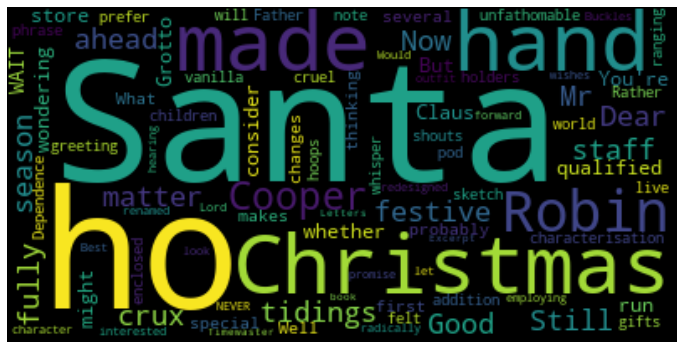

In [59]:
word_cloud = WordCloud().generate(message_body)
plt.figure(figsize=(12,8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Downloading some novels from nltk to play with wordcloud

In [60]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to C:\Users\Nagaraj
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to C:\Users\Nagaraj
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [61]:
# Taking one novel from gutenberg corpus to demo
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

len(example_corpus)

260819

In [62]:
type(example_corpus) 

nltk.corpus.reader.util.StreamBackedCorpusView

In [63]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [64]:
word_list = [''.join(word) for word in example_corpus]
word_list

['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.',
 '(',
 'Supplied',
 'by',
 'a',
 'Late',
 'Consumptive',
 'Usher',
 'to',
 'a',
 'Grammar',
 'School',
 ')',
 'The',
 'pale',
 'Usher',
 '--',
 'threadbare',
 'in',
 'coat',
 ',',
 'heart',
 ',',
 'body',
 ',',
 'and',
 'brain',
 ';',
 'I',
 'see',
 'him',
 'now',
 '.',
 'He',
 'was',
 'ever',
 'dusting',
 'his',
 'old',
 'lexicons',
 'and',
 'grammars',
 ',',
 'with',
 'a',
 'queer',
 'handkerchief',
 ',',
 'mockingly',
 'embellished',
 'with',
 'all',
 'the',
 'gay',
 'flags',
 'of',
 'all',
 'the',
 'known',
 'nations',
 'of',
 'the',
 'world',
 '.',
 'He',
 'loved',
 'to',
 'dust',
 'his',
 'old',
 'grammars',
 ';',
 'it',
 'somehow',
 'mildly',
 'reminded',
 'him',
 'of',
 'his',
 'mortality',
 '.',
 '"',
 'While',
 'you',
 'take',
 'in',
 'hand',
 'to',
 'school',
 'others',
 ',',
 'and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale',
 '-',
 'fish',
 'is',
 'to',
 'be',
 

In [99]:
# Converting list of words string (novel)
novel_as_string = ' '.join(word_list)
# novel_as_string

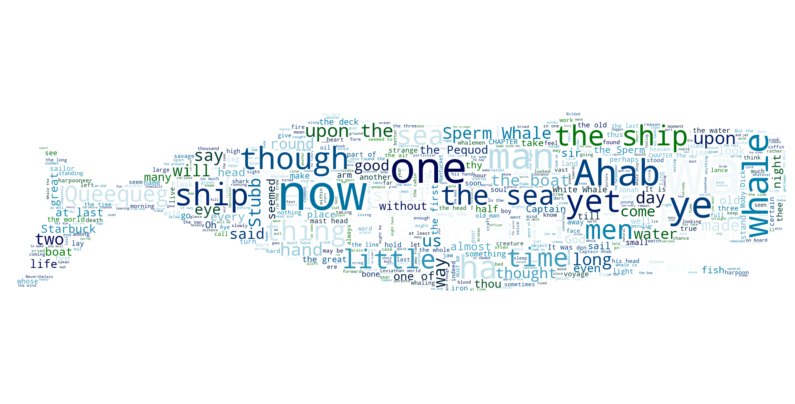

In [80]:
# NOTE : we are converting nltk.corpus.reader.util.StreamBackedCorpusView -> list -> string
# because word cloud requires string input


icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB',size=icon.size , color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=600,colormap='ocean')
word_cloud.generate(novel_as_string)
plt.figure(figsize=(14,10))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [67]:
rgb_array.shape  # pixel by pixel info of all colors

(1024, 2048, 3)

In [68]:
rgb_array[1000,1000]

array([255, 255, 255], dtype=uint8)

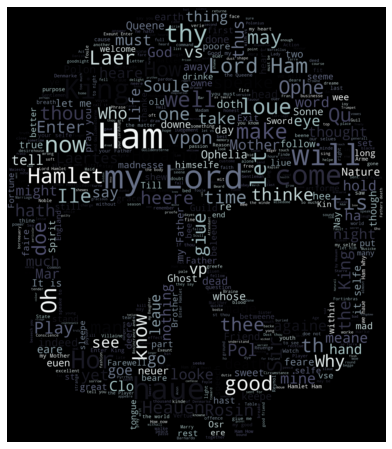

In [69]:
# Using skull image to create wordcloud for shakespeares play hemlet

hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB',size=skull_icon.size,color=(255,255,255))
image_mask.paste(skull_icon,box=skull_icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array,max_words=600,background_color='black',colormap='bone')
word_cloud.generate(hamlet_as_string)


plt.figure(figsize=(16,8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Creating wordcloud for spam and ham messages

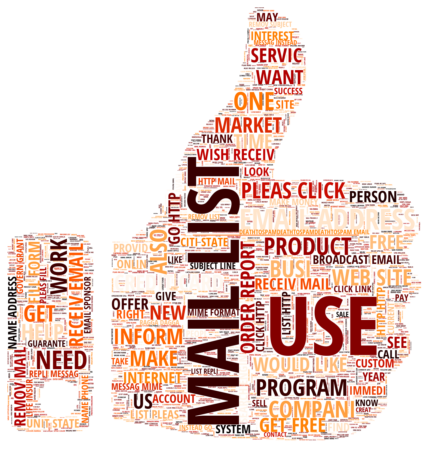

In [78]:
# Generating text as string for spam messages
spam_str = ' '.join(flat_list_spam)

icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array,max_words=2000,background_color='white',max_font_size=300,
                       colormap='gist_heat',font_path=CUSTOM_FONT_FILE)
word_cloud.generate(spam_str.upper())


plt.figure(figsize=(16,8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

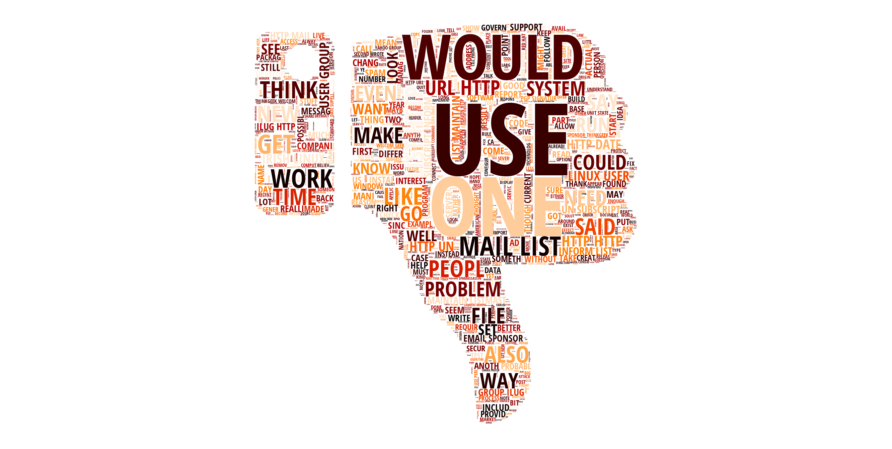

In [79]:
# Generating text as string for ham messages
ham_str = ' '.join(flat_list_ham)

icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array,max_words=2000,background_color='white',max_font_size=300,
                       colormap='gist_heat',font_path=CUSTOM_FONT_FILE)
word_cloud.generate(ham_str.upper())


plt.figure(figsize=(16,8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate vocabulary and dictionary of words

In [81]:
stemmed_nested_list = data['MESSAGE'].apply(clean_messages_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


In [83]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print(f' Total number of unique words : {unique_words.shape[0]}')
unique_words.head()

 Total number of unique words : 27218


http     10648
use       5015
list      4849
email     4366
get       4187
dtype: int64

In [87]:
frequent_words = unique_words[0:VOCABULARY_SIZE]
print( f'Most 10 frequently used words : \n {frequent_words[0:10]}')

Most 10 frequently used words : 
 http     10648
use       5015
list      4849
email     4366
get       4187
mail      3983
one       3905
free      3171
time      3041
work      2880
dtype: int64


## Creating vocacbulary DataFrame with WORD_ID

In [89]:
word_ids = list(range(0,VOCABULARY_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD':frequent_words.index.values})
vocab.index.name= 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the vocabulary to csv file

In [91]:
vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab['VOCAB_WORD'].name)